# Trajectory Analysis using 10x Single Cell Gene Expression Data
More details on this analysis can be found in the 10x Genomics Analysis Guides tutorial, located here: https://www.10xgenomics.com/resources/analysis-guides/trajectory-analysis-using-10x-Genomics-single-cell-gene-expression-data

September 14, 2023

This will install the required Python library packages needed for this tutorial:

In [ ]:
!pip install numpy==1.23 pandas==1.5.3 matplotlib==3.6.0 scanpy==1.9.1 igraph==0.9.8 scvelo==0.2.4 loompy==3.0.6 anndata==0.8.0

This will create a new directory called "input-files", then download and extract several input data files needed for this tutorial, then display the list of files now available.

In [1]:
!mkdir input-files
!curl -o input-files/filtered_feature_bc_matrix.tar.gz https://cf.10xgenomics.com/supp/cell-exp/neutrophils/filtered_feature_bc_matrix.tar.gz
!curl -o input-files/WB_Lysis_3p_Introns_8kCells.loom https://cf.10xgenomics.com/supp/cell-exp/neutrophils/WB_Lysis_3p_Introns_8kCells.loom
!curl -o input-files/3p-Neutrophils-clusters.csv https://cf.10xgenomics.com/supp/cell-exp/neutrophils/3p-Neutrophils-clusters.csv
!curl -o input-files/3p-Neutrophils-UMAP-Projection.csv https://cf.10xgenomics.com/supp/cell-exp/neutrophils/3p-Neutrophils-UMAP-Projection.csv
!tar -xvzf input-files/filtered_feature_bc_matrix.tar.gz -C input-files/
!ls -lah input-files

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.2M  100 16.2M    0     0   9.9M      0  0:00:01  0:00:01 --:--:--  9.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 67.5M  100 67.5M    0     0  14.8M      0  0:00:04  0:00:04 --:--:-- 17.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 96967  100 96967    0     0  99279      0 --:--:-- --:--:-- --:--:-- 99249
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  185k  100  185k    0     0   176k      0  0:00:01  0:00:01 --:--:--  176k
filtered_feature_bc_matrix/
filtered_feature_bc_matr

In [2]:
# First, import required packages in the current session.

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy as sc
import igraph
import scvelo as scv
import loompy as lmp
import anndata

import warnings
warnings.filterwarnings('ignore')

* The scvelo tool only calculates velocity
* Now we need anchors for visualization
* UMAP gives us projections
* barcode assignments are associated with different clusters
* UMAP + clusters come from Loupe

Let's import the 2 files from Loupe.

In [3]:
# Read in the subset of clusters exported from Loupe Browser
Clusters_Loupe = pd.read_csv("./input-files/3p-Neutrophils-clusters.csv", delimiter=',',index_col=0)

# Create list with only Neutrophil Barcodes
# This will be used later to subset the count matrix
Neutrophils_BCs = Clusters_Loupe.index

In [4]:
Clusters_Loupe

Neutrophils
Barcode                       
AAACCCAGTTGTGCAT-1   Cluster 7
AAACGAACAATTGCGT-1   Cluster 1
AAACGCTTCGAGTCCG-1   Cluster 1
AAAGAACAGCGACTAG-1   Cluster 2
AAAGAACAGTCGAGGT-1   Cluster 4
...                        ...
TTTGTTGAGTAAGCAT-1   Cluster 4
TTTGTTGCAACCAACT-1   Cluster 6
TTTGTTGTCGAGTACT-1   Cluster 4
TTTGTTGTCGCTACAA-1   Cluster 4
TTTGTTGTCTTCGCTG-1   Cluster 4

[3343 rows x 1 columns]

In [5]:
# Read UMAP exported from Loupe Browser
UMAP_Loupe = pd.read_csv("./input-files/3p-Neutrophils-UMAP-Projection.csv", delimiter=',',index_col=0)

# Tansform to Numpy (for formatting)
UMAP_Loupe = UMAP_Loupe.to_numpy()

In [6]:
UMAP_Loupe

array([[-1.58232408e-03,  2.18014739e+00],
       [ 5.13504428e+00, -4.40983558e+00],
       [ 6.19052403e+00, -2.85861105e+00],
       ...,
       [ 7.07823770e+00, -3.86301154e+00],
       [ 5.38129839e+00, -5.10858282e+00],
       [ 6.74767682e+00, -1.13205385e+00]])

Now we will import the GEX matrix.



In [7]:
# Define Path to cellranger output
Path10x='./input-files/filtered_feature_bc_matrix/'

# Read filtered feature bc matrix output from cellranger count
Neutro3p = sc.read_10x_mtx(Path10x,var_names='gene_symbols',cache=True)
Neutro3p

AnnData object with n_obs × n_vars = 8000 × 36601
    var: 'gene_ids', 'feature_types'

In [8]:
# These are the barcodes (n_obs) = 8000
# This is the number set in --force-cells
Neutro3p.obs

Empty DataFrame
Columns: []
Index: [AAACCCAAGGCACTCC-1, AAACCCACAACTCCCT-1, AAACCCAGTACGAGCA-1, AAACCCAGTTGTGCAT-1, AAACCCATCTTCGGAA-1, AAACGAAAGAACTTCC-1, AAACGAACAATTGCGT-1, AAACGAACACCGGAAA-1, AAACGAACAGATTTCG-1, AAACGAAGTTGTGGCC-1, AAACGCTAGACAACTA-1, AAACGCTAGGTCACAG-1, AAACGCTAGTAACAGT-1, AAACGCTCACCATAAC-1, AAACGCTCACTGGATT-1, AAACGCTTCGAGTCCG-1, AAAGAACAGCAGCCCT-1, AAAGAACAGCGACTAG-1, AAAGAACAGGGAGGCA-1, AAAGAACAGTCGAGGT-1, AAAGAACCAACCGTGC-1, AAAGAACCACTGCACG-1, AAAGAACCAGTGCGCT-1, AAAGAACGTCCTGTCT-1, AAAGAACTCAGCATCG-1, AAAGAACTCAGCTCTC-1, AAAGAACTCCCGTGTT-1, AAAGAACTCCGCATAA-1, AAAGAACTCGACATCG-1, AAAGAACTCGGCATCG-1, AAAGGATAGGAGCTGT-1, AAAGGATCACCCAAGC-1, AAAGGATCACGCGCAT-1, AAAGGATCAGCTGTAT-1, AAAGGATCAGCTTCCT-1, AAAGGATCAGGAATAT-1, AAAGGATGTATCGTTG-1, AAAGGATTCGACCAAT-1, AAAGGATTCGCAGATT-1, AAAGGGCCAGATGCGA-1, AAAGGGCGTACGAGTG-1, AAAGGGCGTCGATTTG-1, AAAGGGCGTGAATGAT-1, AAAGGGCGTTCAAGTC-1, AAAGGGCTCATTCATC-1, AAAGGGCTCGACCCAG-1, AAAGGGCTCTACCACC-1, AAAGGTAAGACGGTTG-1, AAAGGTAAGATTCGCT-1, AAAGGTAAGTGATCGG-1, AAAGGTACAAAGCAAT-1, AAAGGTACAAGTGGCA-1, AAAGGTACACAGCCTG-1, AAAGGTACATACAGAA-1, AAAGGTACATACAGGG-1, AAAGGTAGTCGAGATG-1, AAAGGTATCATGTCAG-1, AAAGGTATCCAAGCAT-1, AAAGGTATCGCAAGAG-1, AAAGGTATCTAAGCGT-1, AAAGTCCAGCACCGTC-1, AAAGTCCAGTAGGCCA-1, AAAGTCCGTACGGATG-1, AAAGTCCGTATCTCTT-1, AAAGTCCGTTCTCTAT-1, AAAGTCCTCGACACTA-1, AAAGTCCTCTACTGCC-1, AAAGTCCTCTGAGAAA-1, AAAGTCCTCTTAGCCC-1, AAAGTGAAGCGTTAGG-1, AAAGTGACACAAACGG-1, AAAGTGACAGACCAGA-1, AAAGTGAGTATCCCAA-1, AAAGTGAGTATCGCAT-1, AAAGTGAGTTCTAAGC-1, AAAGTGATCAAATAGG-1, AAAGTGATCGCCGAGT-1, AAAGTGATCTACGCAA-1, AAAGTGATCTTCGCTG-1, AAATGGAAGTCCTACA-1, AAATGGAGTACCAATC-1, AAATGGAGTAGTCACT-1, AAATGGAGTATCAAGA-1, AAATGGATCACCGGTG-1, AAATGGATCATCACAG-1, AACAAAGAGAACAAGG-1, AACAAAGCAATGTCAC-1, AACAAAGCAGTAACGG-1, AACAAAGGTCACTCGG-1, AACAAAGGTCCTATAG-1, AACAAAGTCCTCGATC-1, AACAAAGTCTGCCTGT-1, AACAACCCAGAGGCTA-1, AACAACCGTGTCACAT-1, AACAACCTCACAACCA-1, AACAACCTCATCGACA-1, AACAACCTCATGGCCG-1, AACAACCTCCCGAGGT-1, AACAACCTCCTCTCTT-1, AACAACCTCGACCTAA-1, ...]

[8000 rows x 0 columns]

In [9]:
# These are the gene_ids (n_vars) = 36,601
Neutro3p.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

In [10]:
Neutro3p_df = Neutro3p.to_df()
Neutro3p_df.head()

MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  \
AAACCCAAGGCACTCC-1          0.0      0.0    0.0         0.0         0.0   
AAACCCACAACTCCCT-1          0.0      0.0    0.0         0.0         0.0   
AAACCCAGTACGAGCA-1          0.0      0.0    0.0         0.0         0.0   
AAACCCAGTTGTGCAT-1          0.0      0.0    0.0         0.0         0.0   
AAACCCATCTTCGGAA-1          0.0      0.0    0.0         0.0         0.0   

                    AL627309.2  AL627309.5  AL627309.4  AP006222.2  \
AAACCCAAGGCACTCC-1         0.0         0.0         0.0         0.0   
AAACCCACAACTCCCT-1         0.0         0.0         0.0         0.0   
AAACCCAGTACGAGCA-1         0.0         0.0         0.0         0.0   
AAACCCAGTTGTGCAT-1         0.0         0.0         0.0         0.0   
AAACCCATCTTCGGAA-1         0.0         0.0         0.0         0.0   

                    AL732372.1  ...  AC133551.1  AC136612.1  AC136616.1  \
AAACCCAAGGCACTCC-1         0.0  ...         0.0         0.0         0.0   
AAACCCACAACTCCCT-1         0.0  ...         0.0         0.0         0.0   
AAACCCAGTACGAGCA-1         0.0  ...         0.0         0.0         0.0   
AAACCCAGTTGTGCAT-1         0.0  ...         0.0         0.0         0.0   
AAACCCATCTTCGGAA-1         0.0  ...         0.0         0.0         0.0   

                    AC136616.3  AC136616.2  AC141272.1  AC023491.2  \
AAACCCAAGGCACTCC-1         0.0         0.0         0.0         0.0   
AAACCCACAACTCCCT-1         0.0         0.0         0.0         0.0   
AAACCCAGTACGAGCA-1         0.0         0.0         0.0         0.0   
AAACCCAGTTGTGCAT-1         0.0         0.0         0.0         0.0   
AAACCCATCTTCGGAA-1         0.0         0.0         0.0         0.0   

                    AC007325.1  AC007325.4  AC007325.2  
AAACCCAAGGCACTCC-1         0.0         0.0         0.0  
AAACCCACAACTCCCT-1         0.0         0.0         0.0  
AAACCCAGTACGAGCA-1         0.0         0.0         0.0  
AAACCCAGTTGTGCAT-1         0.0         0.0         0.0  
AAACCCATCTTCGGAA-1         0.0         0.0         0.0  

[5 rows x 36601 columns]

The earlier matrix was the full dataset.
But we are only interested in neutrophils. So, we need to subset the matrix into only neutrophils
First, we need to define which barcodes are associated with which cluster

In [11]:
# Filter Cells to only Neutrophils
Neutro3p = Neutro3p[Neutrophils_BCs]

# Add Clusters from Loupe to object
Neutro3p.obs['Loupe'] = Clusters_Loupe

# Add UMAP from Loupe to object
Neutro3p.obsm["X_umap"] = UMAP_Loupe

In [12]:
Neutro3p

AnnData object with n_obs × n_vars = 3343 × 36601
    obs: 'Loupe'
    var: 'gene_ids', 'feature_types'
    obsm: 'X_umap'

You might get this warning below, but nothing to worry about.
> Trying to set attribute `.obs` of view, copying.

Next, read velocyto output and merge

In [13]:
# Read velocyto output
VelNeutro3p = scv.read('./input-files/WB_Lysis_3p_Introns_8kCells.loom', cache=True)

# Merge velocyto and cellranger outputs
Neutro3p = scv.utils.merge(Neutro3p, VelNeutro3p)

Neutro3p

AnnData object with n_obs × n_vars = 3343 × 36601
    obs: 'Loupe', 'Clusters', '_X', '_Y', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'gene_ids', 'feature_types', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_umap'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

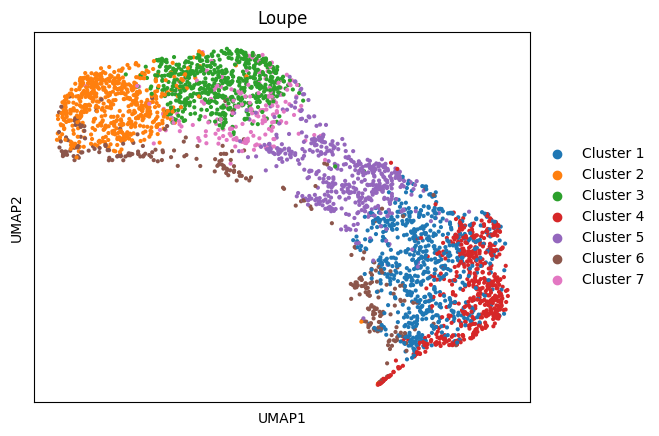

In [16]:
sc.pl.umap(Neutro3p, color='Loupe')

You might get this warning, but no need to worry:
> Variable names are not unique. To make them unique, call `.var_names_make_unique`.

Next, process dataset and obtain latent time values for each cell


In [18]:
# Standard scvelo processing to run Dynamical Mode
scv.pp.filter_and_normalize(Neutro3p, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(Neutro3p, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(Neutro3p, n_jobs=24)
scv.tl.velocity(Neutro3p, mode='dynamical')
scv.tl.velocity_graph(Neutro3p, n_jobs=24)
scv.tl.recover_latent_time(Neutro3p)

Neutro3p

Filtered out 35468 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:23) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/2 cores)


  0%|          | 0/67 [00:00<?, ?gene/s]

    finished (0:00:41) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/2 cores)


  0%|          | 0/3343 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 3 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


AnnData object with n_obs × n_vars = 3343 × 1133
    obs: 'Loupe', 'Clusters', '_X', '_Y', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'gene_ids', 'feature_types', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'Loupe_colors', 'pca', 'neighbors', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs', 'loss'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

computing velocity embedding
    finished (0:00:03) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


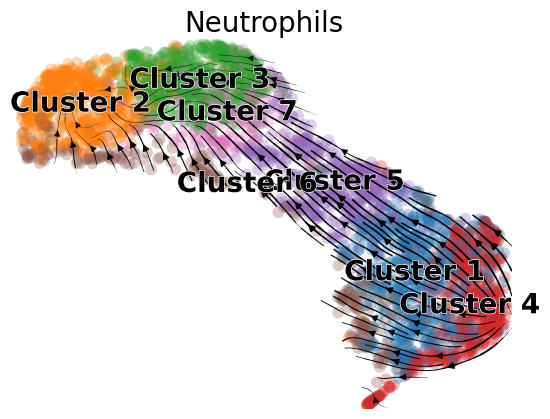

In [20]:
# velocity plo
# default plotting parameters
scv.pl.velocity_embedding_stream(Neutro3p,basis="umap",color="Loupe",title='Neutrophils',fontsize=20,legend_fontsize=20,min_mass=2)

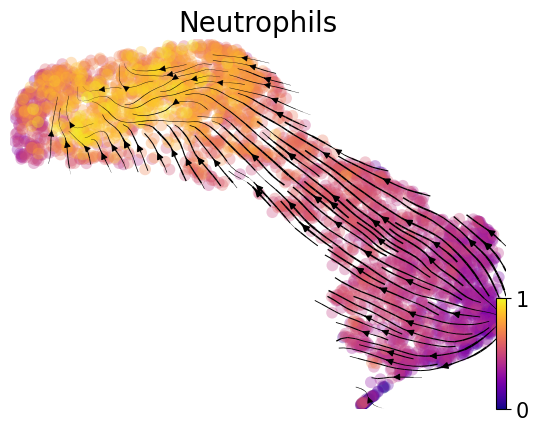

In [21]:
scv.pl.velocity_embedding_stream(Neutro3p,basis="umap",color="latent_time",title='Neutrophils',fontsize=20,legend_fontsize=20,min_mass=2,color_map="plasma")

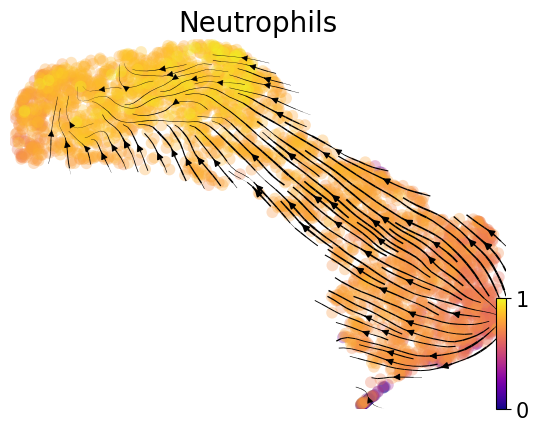

In [25]:
scv.pl.velocity_embedding_stream(Neutro3p,basis="umap",color="velocity_pseudotime",title='Neutrophils',fontsize=20,legend_fontsize=20,min_mass=2,color_map="plasma")

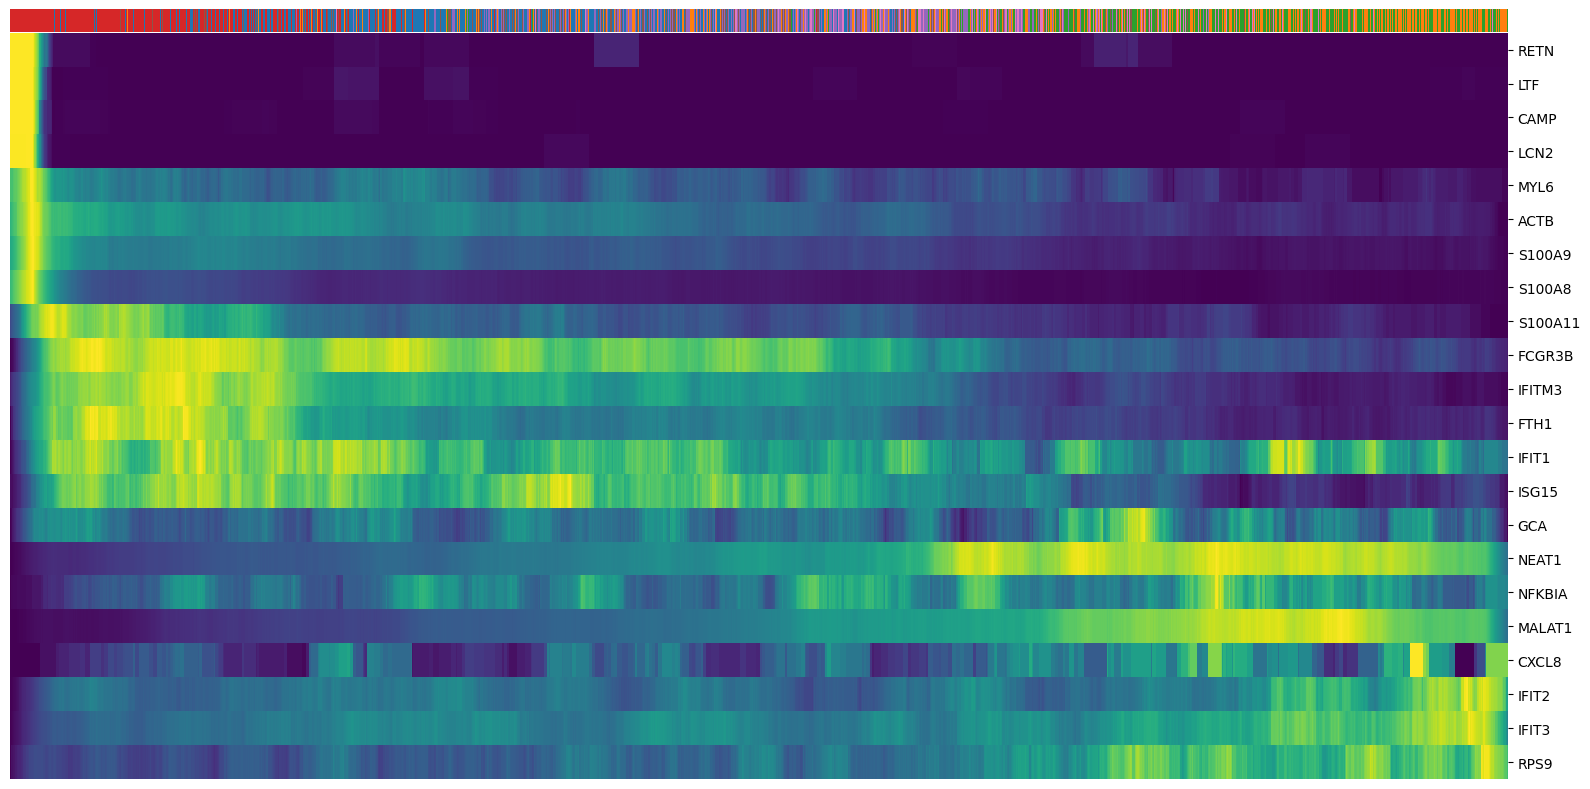

In [26]:
Genes=["RETN","LTF","CAMP","ACTB","GCA","LCN2",
         "S100A8","MYL6","S100A9","FCGR3B","S100A11","FTH1","IFIT1",
         "IFITM3","IFIT3","ISG15","IFIT2","RPS9","NEAT1","MALAT1","NFKBIA","CXCL8"]
scv.pl.heatmap(Neutro3p, var_names=Genes, sortby='latent_time', col_color='Loupe', n_convolve=100,figsize=(16,8),yticklabels=True,sort=True,colorbar=True,show=True,layer="count")

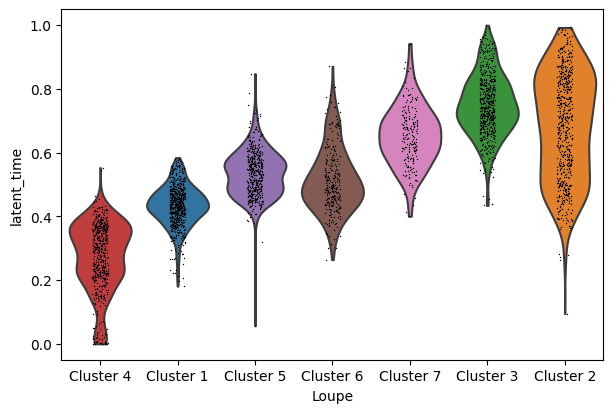

In [27]:
sc.pl.violin(Neutro3p, keys='latent_time',groupby="Loupe",order=["Cluster 4","Cluster 1","Cluster 5","Cluster 6","Cluster 7","Cluster 3","Cluster 2"])

In [33]:
Neutro3p.obs

Loupe Clusters         _X         _Y  \
AAACCCAGTTGTGCAT  Cluster 7        0 -14.673952 -21.829342   
AAACGAACAATTGCGT  Cluster 1        7  13.169840 -23.040810   
AAACGCTTCGAGTCCG  Cluster 1        0  -7.547290 -18.359982   
AAAGAACAGCGACTAG  Cluster 2        7   2.599221 -13.197364   
AAAGAACAGTCGAGGT  Cluster 4       12  30.789263  37.079979   
...                     ...      ...        ...        ...   
TTTGTTGAGTAAGCAT  Cluster 4        8   6.077382  10.426246   
TTTGTTGCAACCAACT  Cluster 6        0 -20.034956 -22.656347   
TTTGTTGTCGAGTACT  Cluster 4        5 -21.395502  -8.034902   
TTTGTTGTCGCTACAA  Cluster 4        4  -4.352460  37.889736   
TTTGTTGTCTTCGCTG  Cluster 4        4  -7.391890  35.414295   

                  initial_size_spliced  initial_size_unspliced  initial_size  \
AAACCCAGTTGTGCAT                   125                     665         125.0   
AAACGAACAATTGCGT                   374                    1133         374.0   
AAACGCTTCGAGTCCG                   182                     282         182.0   
AAAGAACAGCGACTAG                    58                     236          58.0   
AAAGAACAGTCGAGGT                   436                     679         436.0   
...                                ...                     ...           ...   
TTTGTTGAGTAAGCAT                   361                     671         361.0   
TTTGTTGCAACCAACT                   212                     459         212.0   
TTTGTTGTCGAGTACT                   228                     384         228.0   
TTTGTTGTCGCTACAA                   616                    1484         616.0   
TTTGTTGTCTTCGCTG                   431                     751         431.0   

                     n_counts  velocity_self_transition  root_cells  \
AAACCCAGTTGTGCAT  1172.159912                  0.019352    0.000564   
AAACGAACAATTGCGT   708.144470                  0.004343    0.003165   
AAACGCTTCGAGTCCG   469.615387                  0.005987    0.001637   
AAAGAACAGCGACTAG   865.034485                  0.069053    0.001910   
AAAGAACAGTCGAGGT   441.963318                  0.014892    0.002179   
...                       ...                       ...         ...   
TTTGTTGAGTAAGCAT   509.185608                  0.105711    0.001456   
TTTGTTGCAACCAACT   611.547180                  0.011474    0.000950   
TTTGTTGTCGAGTACT   494.631592                  0.041888    0.002786   
TTTGTTGTCGCTACAA   604.733826                  0.023808    0.010319   
TTTGTTGTCTTCGCTG   479.025574                  0.020966    0.005009   

                    end_points  velocity_pseudotime  latent_time  
AAACCCAGTTGTGCAT  1.739862e-01             0.808026     0.729275  
AAACGAACAATTGCGT  1.715435e-05             0.753127     0.454121  
AAACGCTTCGAGTCCG  5.779722e-05             0.736812     0.349806  
AAAGAACAGCGACTAG  1.460625e-02             0.777196     0.557937  
AAAGAACAGTCGAGGT  1.017349e-06             0.668812     0.331133  
...                        ...                  ...          ...  
TTTGTTGAGTAAGCAT  2.402997e-07             0.703003     0.373369  
TTTGTTGCAACCAACT  1.451285e-03             0.774390     0.464316  
TTTGTTGTCGAGTACT  8.694396e-08             0.665609     0.285270  
TTTGTTGTCGCTACAA  2.048394e-08             0.656141     0.295331  
TTTGTTGTCTTCGCTG  7.469683e-08             0.672501     0.349946  

[3343 rows x 13 columns]

In [34]:
Neutro3p.var

gene_ids    feature_types        Accession Chromosome  \
ISG15    ENSG00000187608  Gene Expression  ENSG00000187608          1   
NADK     ENSG00000008130  Gene Expression  ENSG00000008130          1   
GNB1     ENSG00000078369  Gene Expression  ENSG00000078369          1   
RERE     ENSG00000142599  Gene Expression  ENSG00000142599          1   
PIK3CD   ENSG00000171608  Gene Expression  ENSG00000171608          1   
...                  ...              ...              ...        ...   
HNRNPH2  ENSG00000126945  Gene Expression  ENSG00000126945          X   
ACSL4    ENSG00000068366  Gene Expression  ENSG00000068366          X   
DOCK11   ENSG00000147251  Gene Expression  ENSG00000147251          X   
IL13RA1  ENSG00000131724  Gene Expression  ENSG00000131724          X   
FGF13    ENSG00000129682  Gene Expression  ENSG00000129682          X   

               End      Start Strand    fit_r2  fit_alpha  fit_beta  ...  \
ISG15      1014540    1001138      +  0.072980   0.336245  3.368193  ...   
NADK       1780457    1751232      - -1.376042        NaN       NaN  ...   
GNB1       1891117    1785285      - -2.067874        NaN       NaN  ...   
RERE       8848921    8352397      - -6.911257        NaN       NaN  ...   
PIK3CD     9729114    9651731      + -2.106832        NaN       NaN  ...   
...            ...        ...    ...       ...        ...       ...  ...   
HNRNPH2  101414133  101408222      + -0.250801        NaN       NaN  ...   
ACSL4    109733403  109624244      - -5.827008        NaN       NaN  ...   
DOCK11   118686163  118495898      + -5.827407        NaN       NaN  ...   
IL13RA1  118794535  118727133      + -1.134628        NaN       NaN  ...   
FGF13    139222777  138614727      - -3.632040        NaN       NaN  ...   

         fit_std_s  fit_likelihood  fit_u0  fit_s0  fit_pval_steady  \
ISG15      0.25866        0.191564     0.0     0.0         0.467428   
NADK           NaN             NaN     NaN     NaN              NaN   
GNB1           NaN             NaN     NaN     NaN              NaN   
RERE           NaN             NaN     NaN     NaN              NaN   
PIK3CD         NaN             NaN     NaN     NaN              NaN   
...            ...             ...     ...     ...              ...   
HNRNPH2        NaN             NaN     NaN     NaN              NaN   
ACSL4          NaN             NaN     NaN     NaN              NaN   
DOCK11         NaN             NaN     NaN     NaN              NaN   
IL13RA1        NaN             NaN     NaN     NaN              NaN   
FGF13          NaN             NaN     NaN     NaN              NaN   

         fit_steady_u  fit_steady_s  fit_variance  fit_alignment_scaling  \
ISG15        0.106485      0.746816      1.159787               2.259035   
NADK              NaN           NaN           NaN                    NaN   
GNB1              NaN           NaN           NaN                    NaN   
RERE              NaN           NaN           NaN                    NaN   
PIK3CD            NaN           NaN           NaN                    NaN   
...               ...           ...           ...                    ...   
HNRNPH2           NaN           NaN           NaN                    NaN   
ACSL4             NaN           NaN           NaN                    NaN   
DOCK11            NaN           NaN           NaN                    NaN   
IL13RA1           NaN           NaN           NaN                    NaN   
FGF13             NaN           NaN           NaN                    NaN   

         velocity_genes  
ISG15              True  
NADK              False  
GNB1              False  
RERE              False  
PIK3CD            False  
...                 ...  
HNRNPH2           False  
ACSL4             False  
DOCK11            False  
IL13RA1           False  
FGF13             False  

[1133 rows x 24 columns]

This chunk of code below is used to customize colors for the cluster and plot sizes

In [28]:
# Customize parameters for plots (Size, Color, etc)
# let's set these to improve our plots
scv.set_figure_params(style="scvelo")
pl.rcParams["figure.figsize"] = (10,10)
Colorss=["#E41A1C","#377EB8","#4DAF4A","#984EA3","#FF7F00","#FFFF33","#A65628","#F781BF"]

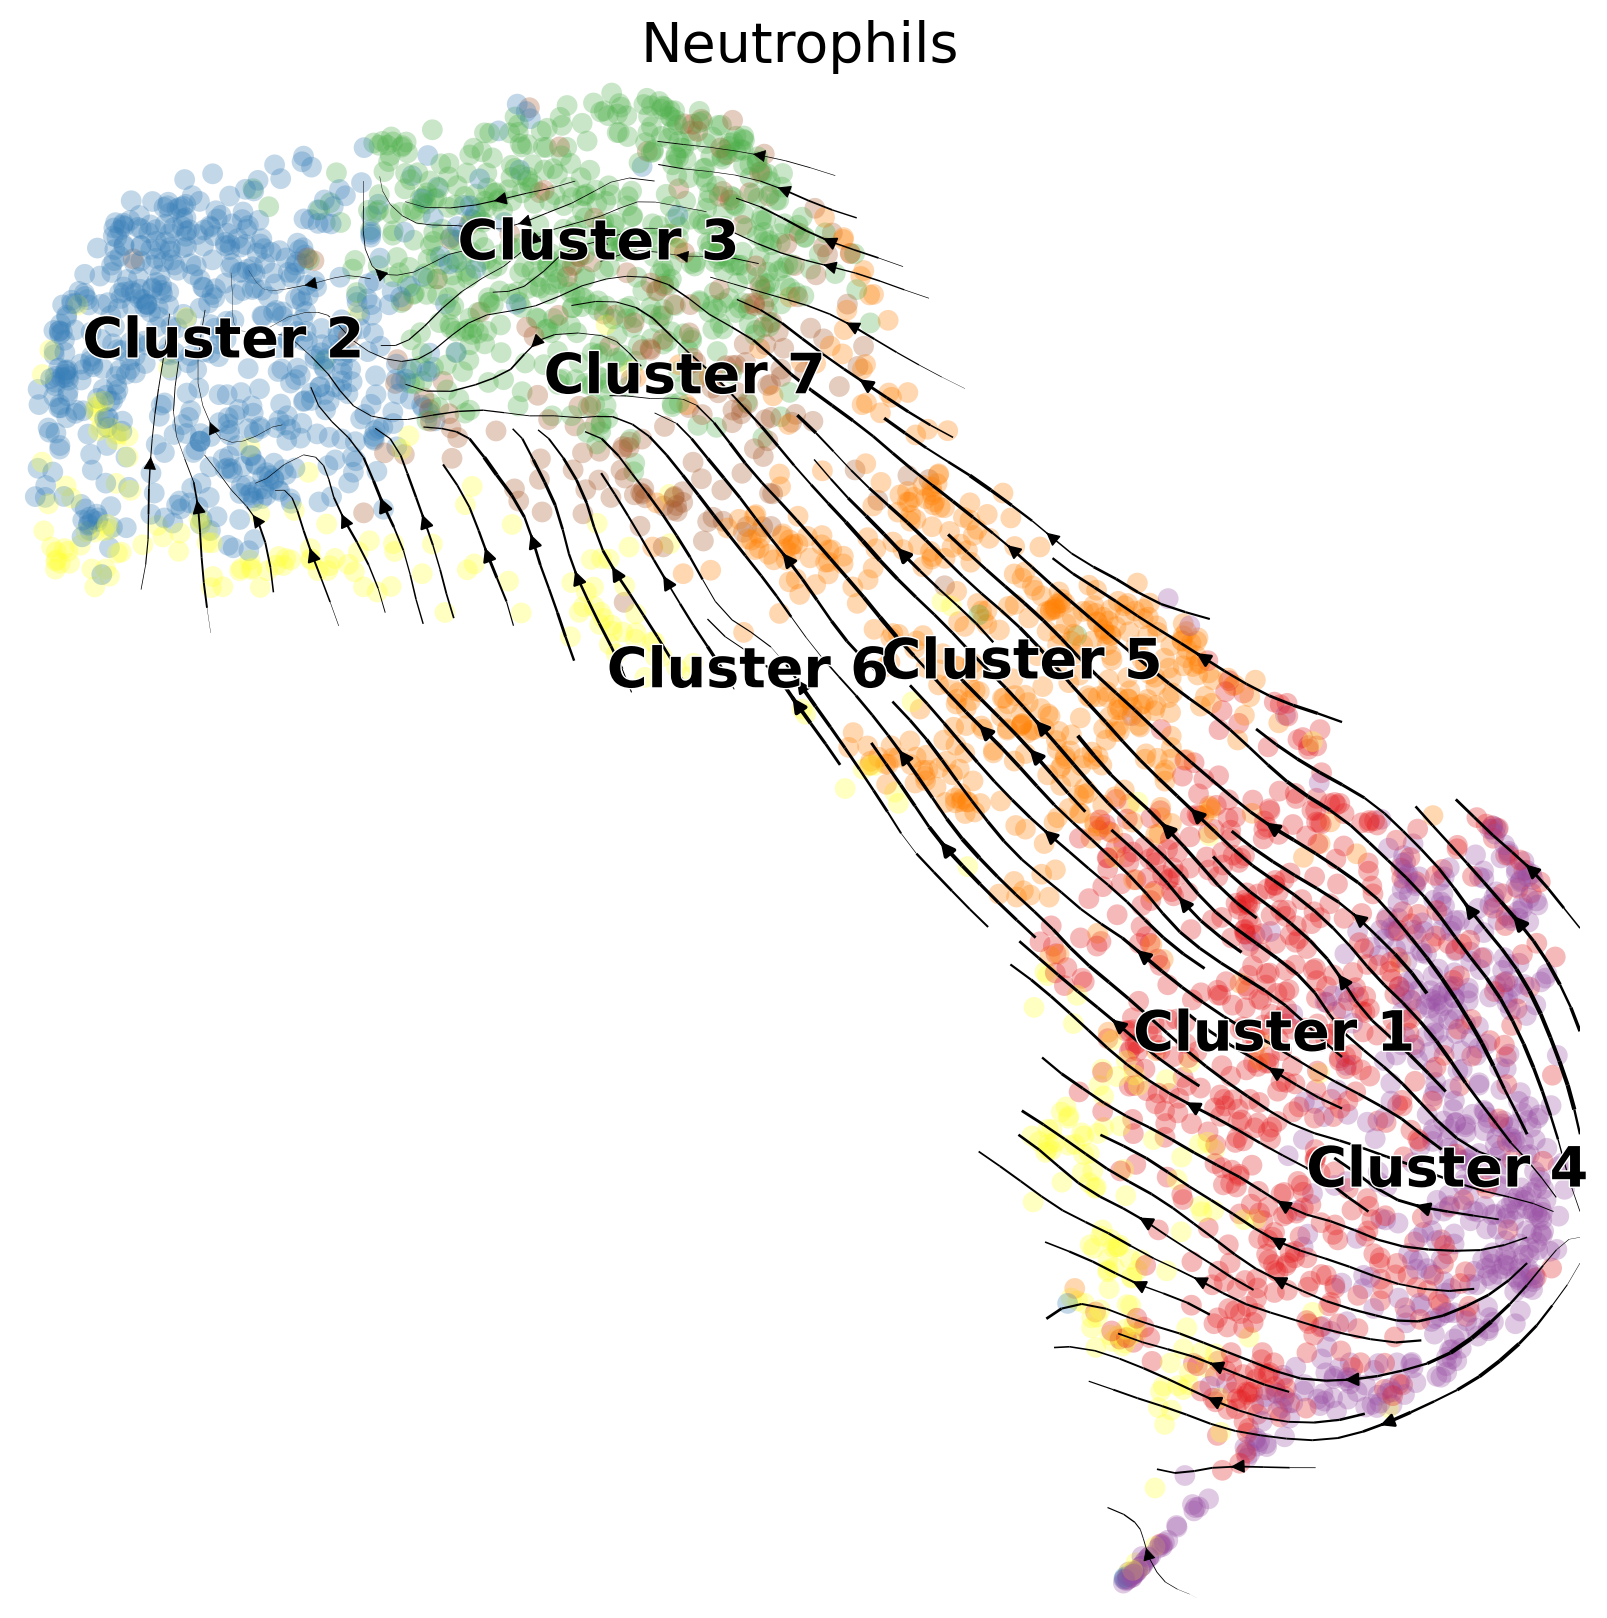

In [32]:
scv.pl.velocity_embedding_stream(Neutro3p,basis="umap",color="Loupe",title='Neutrophils',fontsize=20,legend_fontsize=20,min_mass=2,palette=Colorss)

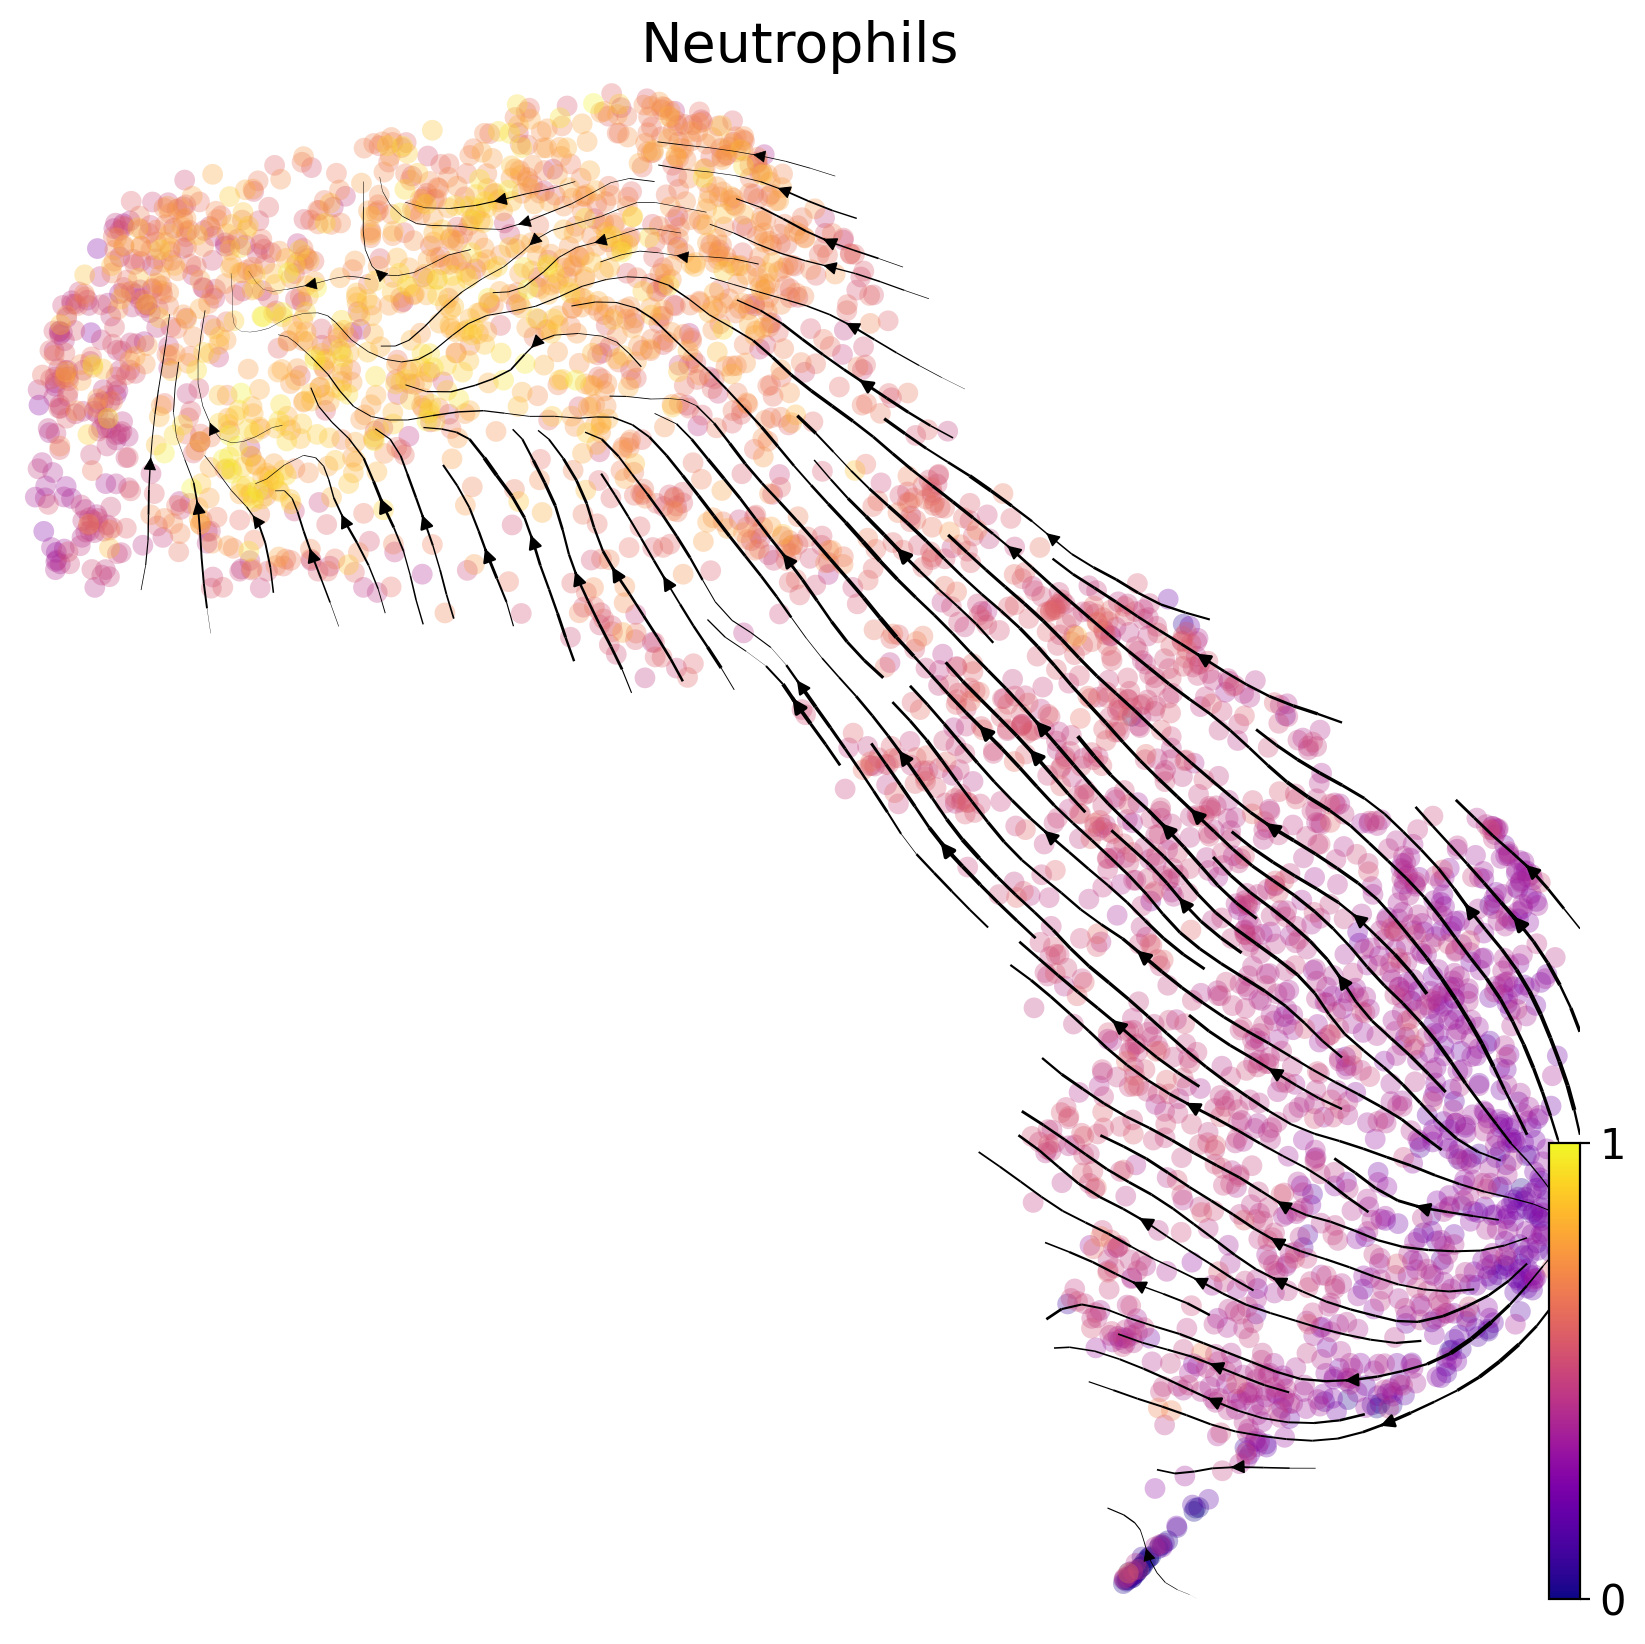

In [29]:
scv.pl.velocity_embedding_stream(Neutro3p,basis="umap",color="latent_time",title='Neutrophils',fontsize=20,legend_fontsize=20,min_mass=2,color_map="plasma")

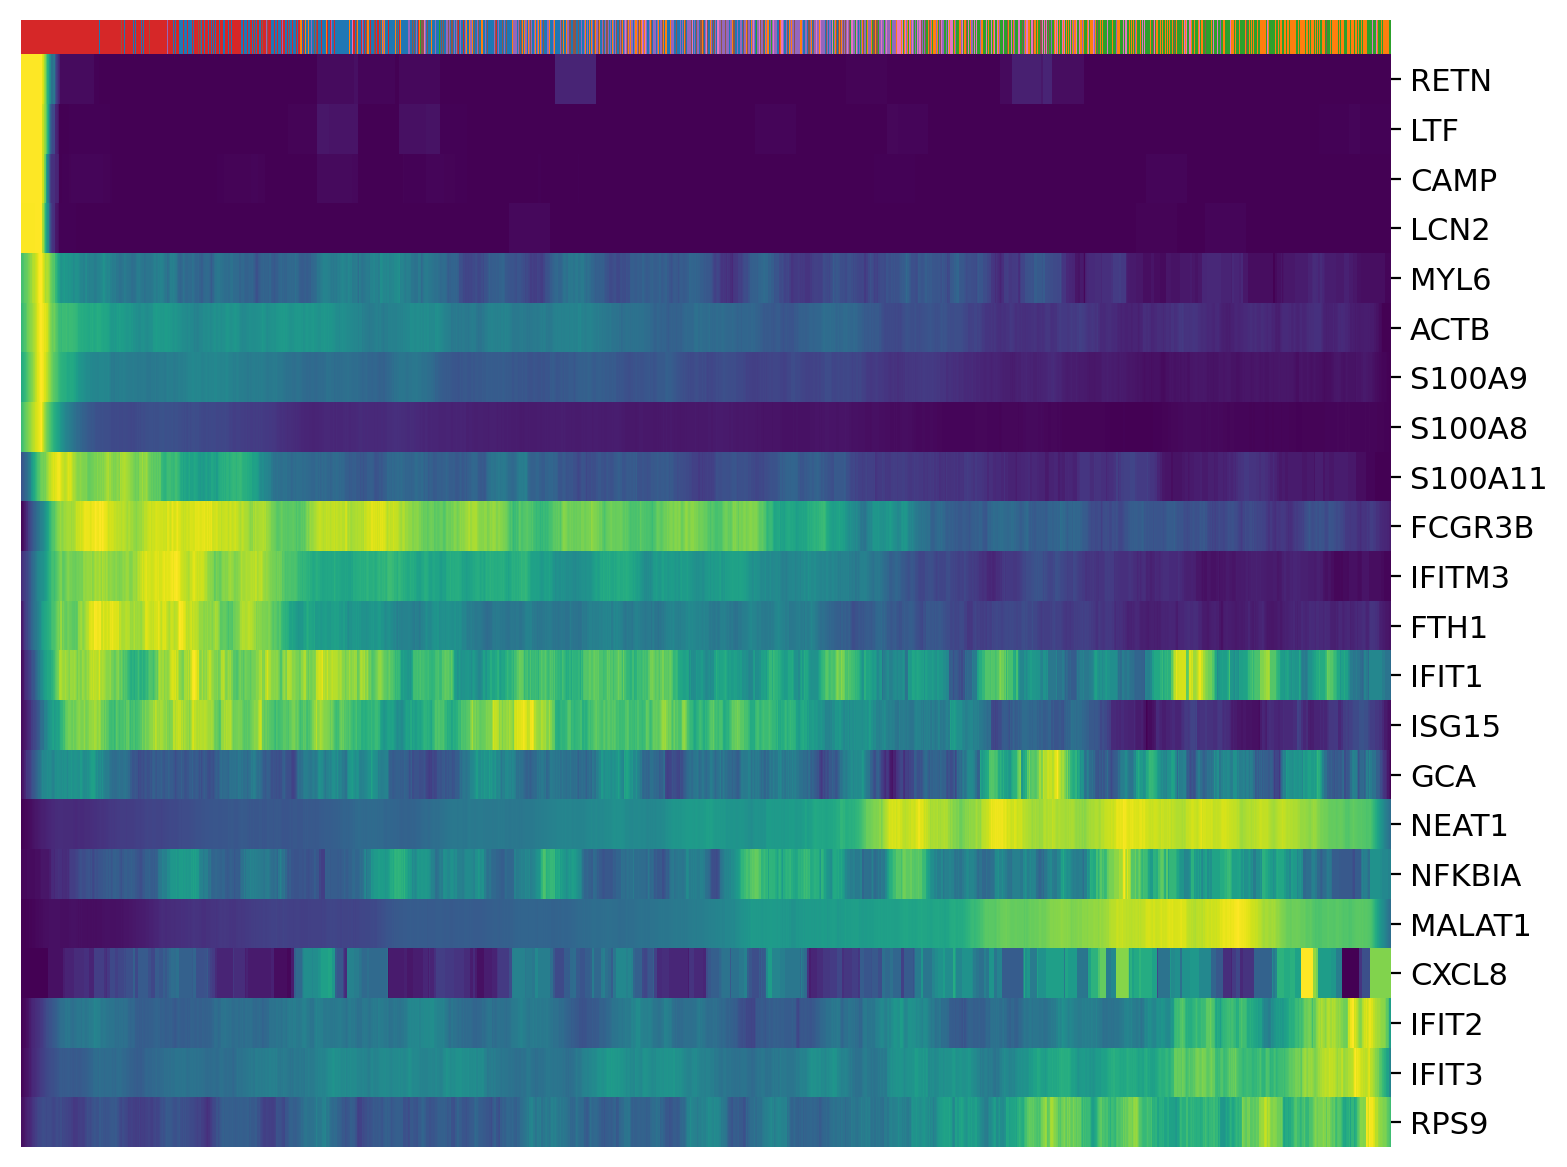

In [30]:
scv.pl.heatmap(Neutro3p, var_names=Genes, sortby='latent_time', col_color='Loupe', n_convolve=100,figsize=(8,6),yticklabels=True,sort=True,colorbar=True,show=True,layer="count")

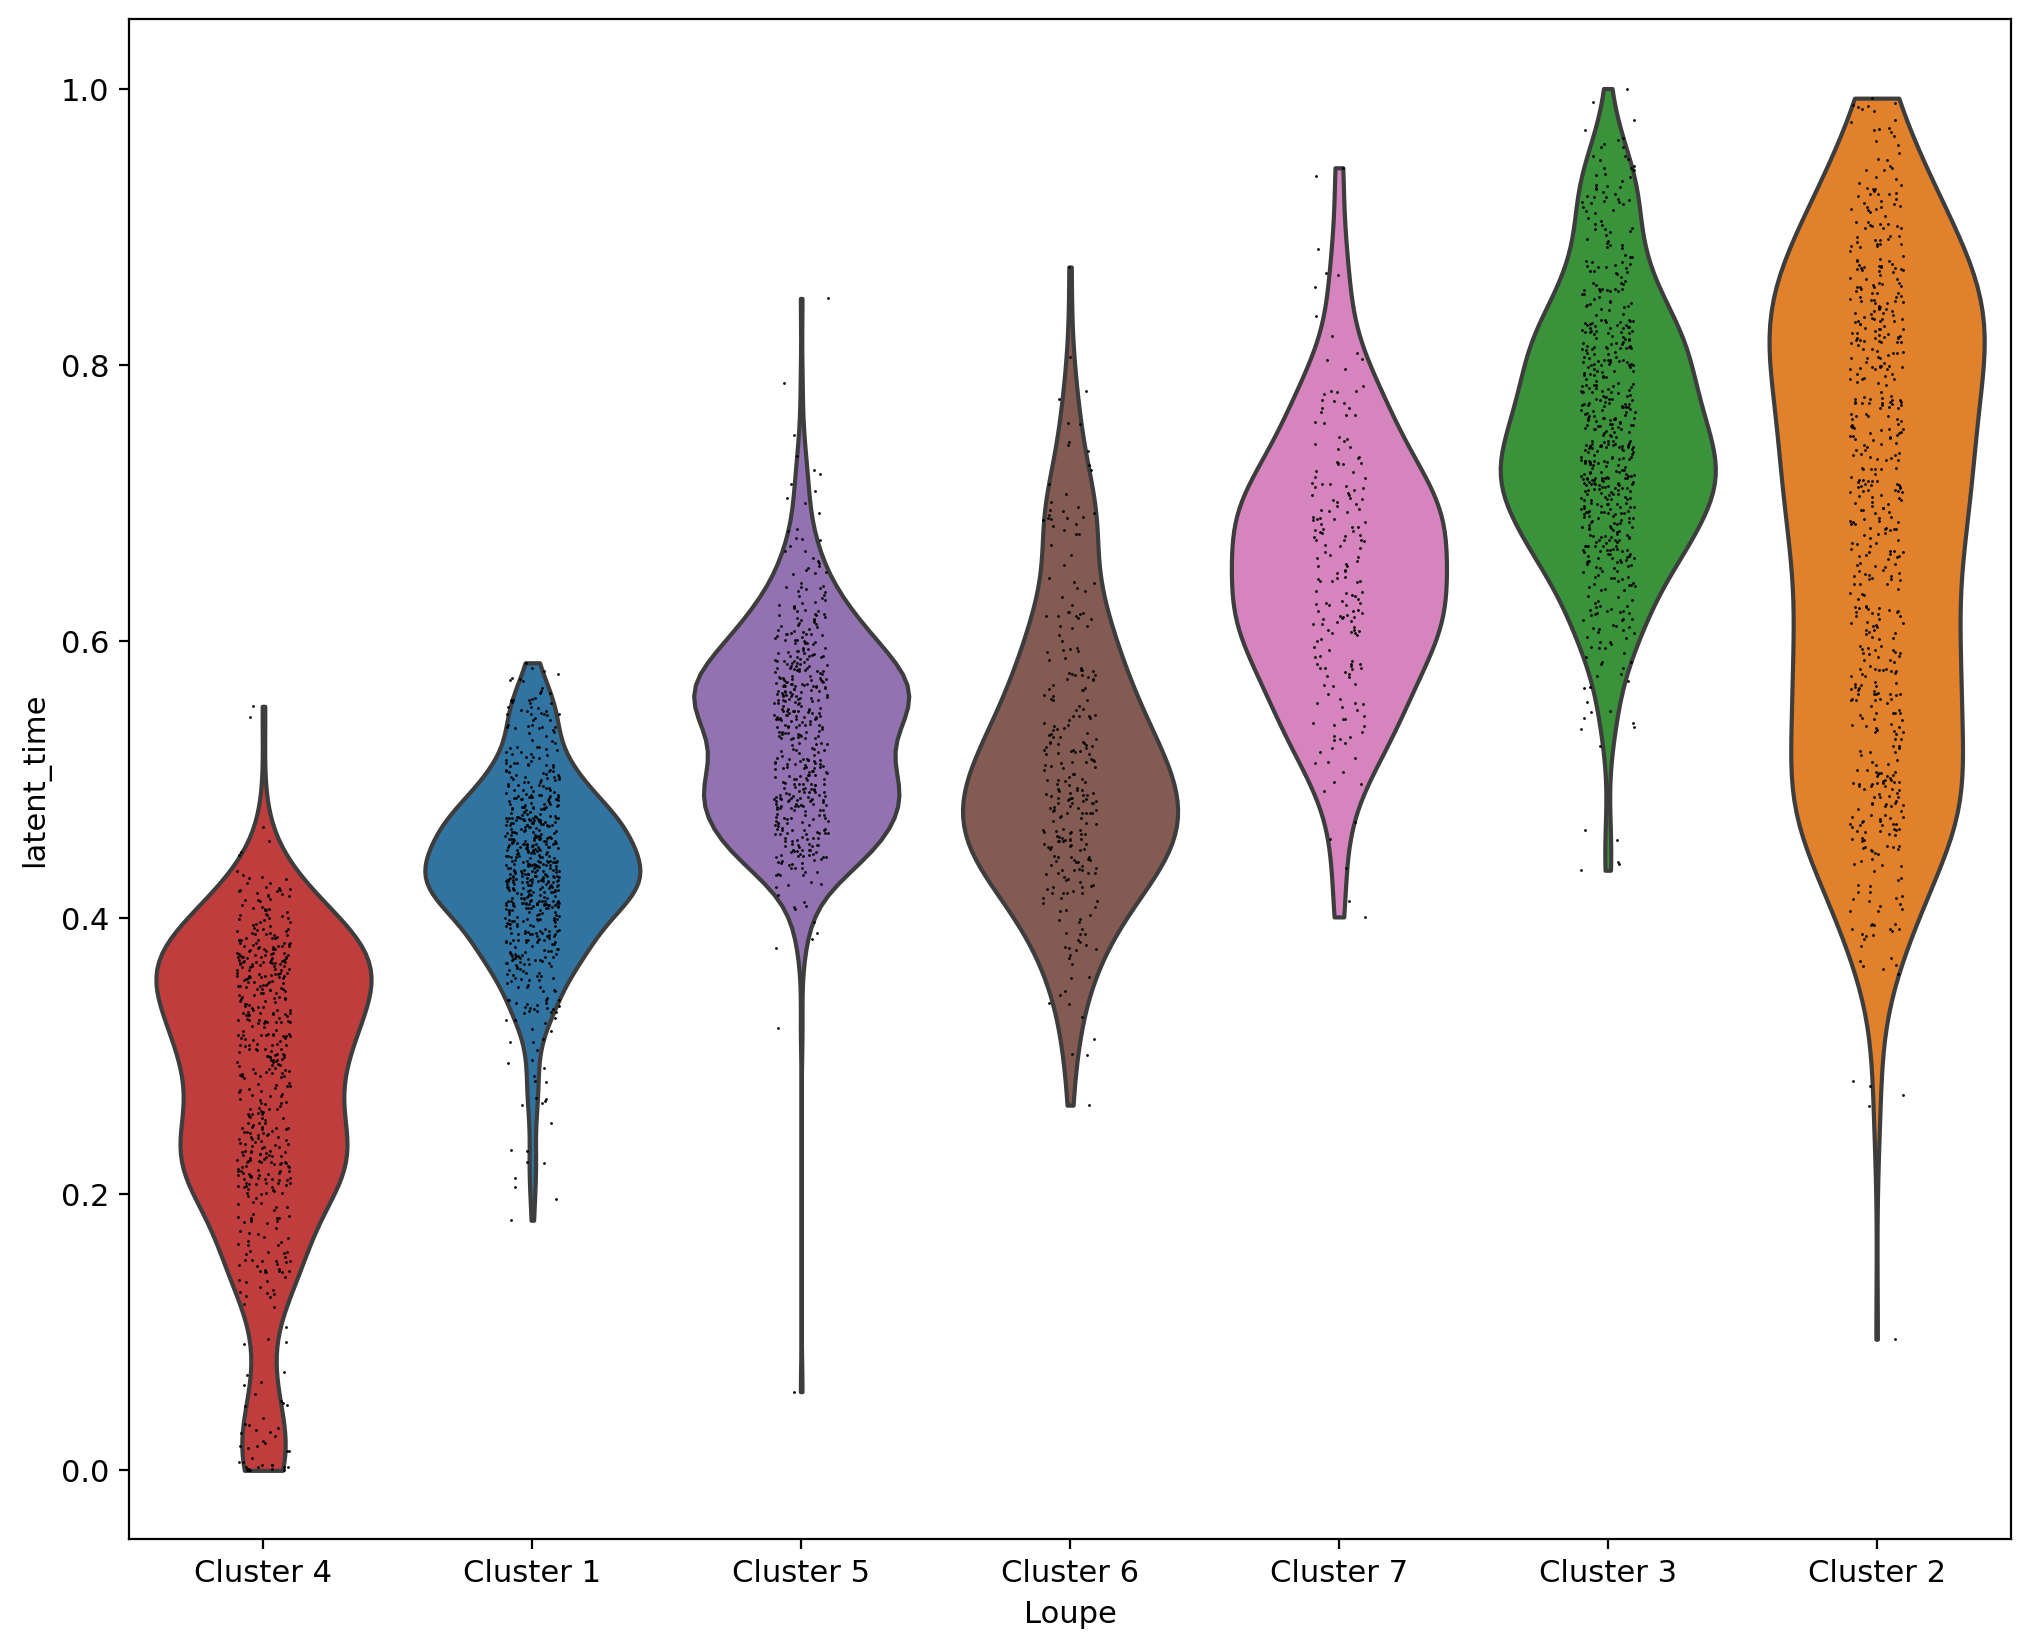

In [31]:
sc.pl.violin(Neutro3p, keys='latent_time',groupby="Loupe",order=["Cluster 4","Cluster 1","Cluster 5","Cluster 6","Cluster 7","Cluster 3","Cluster 2"])

For additional information on analysis using this [10x neutrophils dataset](https://www.10xgenomics.com/resources/datasets/whole-blood-rbc-lysis-for-pbmcs-neutrophils-granulocytes-3-3-1-standard), please see this Tech Note, [Neutrophil Analysis in 10x Genomics Single Cell Gene Expression Assays](https://www.10xgenomics.com/support/single-cell-gene-expression/documentation/steps/sample-prep/neutrophil-analysis-in-10-x-genomics-single-cell-gene-expression-assays)